In [1]:
import os
import operator
import random

import pandas as pd
import numpy as np
import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from vixstructure.models import term_structure_to_spread_price_v2
from vixstructure.utils import parse_model_repr
from vixstructure.data import LongPricesDataset

In [2]:
directory, _, files = next(os.walk("models/experiment02"))
h5_files = tuple(file for file in files if os.path.splitext(file)[1] == ".h5")
csv_files = tuple(file for file in files if os.path.splitext(file)[1] == ".csv")
stats = [(parse_model_repr(os.path.splitext(file)[0]),
          pd.read_csv(os.path.join(directory, file), header=0, index_col=0,
                      dtype={"epoch":int, "loss":np.float32, "val_loss":np.float32}))
         for file in csv_files]
parameters, stats_data = zip(*stats)
dataframe = pd.concat(stats_data, keys=[(p.depth, p.width) for p in parameters],
                      names=["depth", "width"])

In [3]:
# Get mean and standard derivation.
def reduce_mean_std(dataframe):
    groups = dataframe.groupby(("depth", "width", "epoch"))
    mean = groups.mean()
    std = groups.std()
    return pd.concat((mean, std), axis=1, keys=("mean", "std"))
reduced_data = reduce_mean_std(dataframe).loc[1]

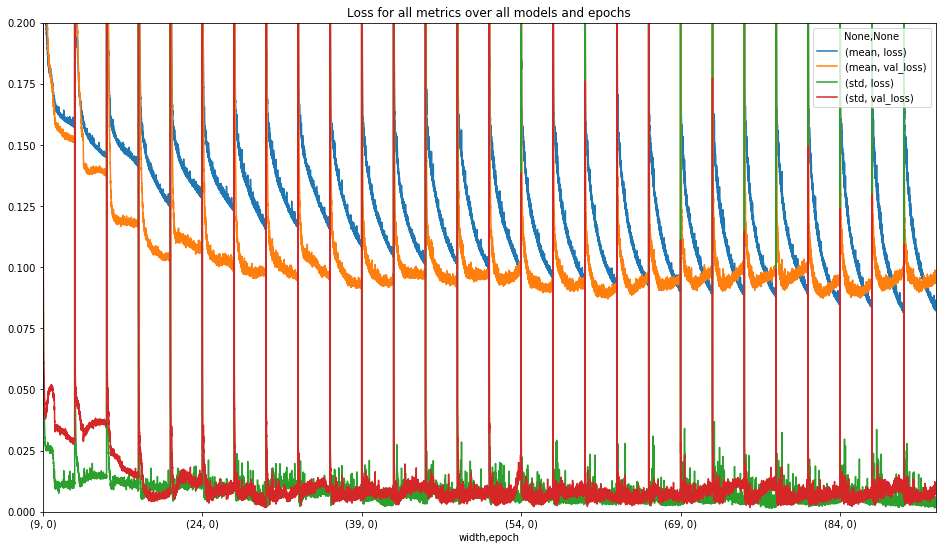

In [4]:
reduced_data.plot(figsize=(16,9))
plt.ylim(0, 0.2)
plt.title("Loss for all metrics over all models and epochs")
plt.show()

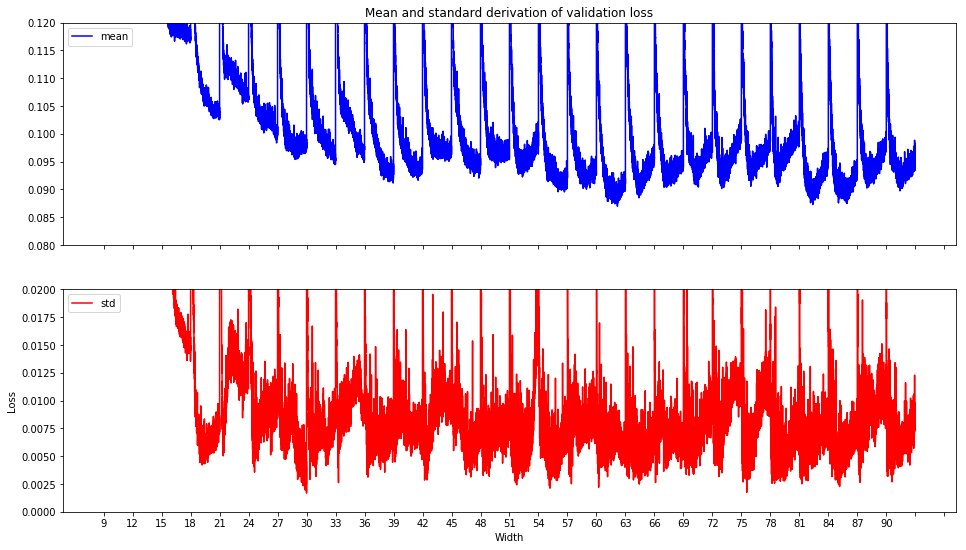

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))
p1 = ax1.plot(np.arange(len(reduced_data)), reduced_data["mean", "val_loss"].values, "b")[0]
ax1.set_ylim(0.08, 0.12)
ax1.legend(("mean",), loc="upper left")
ax2.plot(np.arange(len(reduced_data)), reduced_data["std", "val_loss"].values, "r")
ax2.set_ylim(0.000, 0.02)
ax2.legend(("std",), loc="upper left")
plt.xticks(np.arange(30000, step=1000), reduced_data["mean", "val_loss"].index.levels[0])
plt.xlabel("Width")
plt.ylabel("Loss")
ax1.set_title("Mean and standard derivation of validation loss")
plt.show()

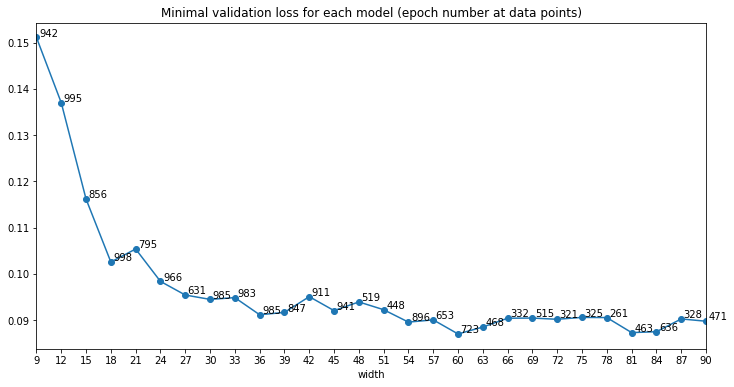

In [6]:
best_epochs = reduced_data["mean", "val_loss"].groupby("width").min()
best_epochs.plot(style='o-', figsize=(12,6))
for argmin_width, argmin_epoch in reduced_data["mean", "val_loss"].groupby("width").idxmin():
    plt.text(argmin_width+0.3, best_epochs[argmin_width]+0.0003, argmin_epoch)
plt.title("Minimal validation loss for each model (epoch number at data points)")
plt.xticks(np.arange(9, 90+1, 3))
plt.show()

In [7]:
model_ex2 = term_structure_to_spread_price_v2(1, 21)
model_ex2.load_weights("models/experiment02/20170707105137_tfpool19_depth1_width21_dropout0e+00_optimAdam_lr1e-03.h5")
dataset = LongPricesDataset("data/8_m_settle.csv", "data/expirations.csv")
(x_train, y_train), (x_val, y_val), (x_test, y_test) = dataset.splitted_dataset()

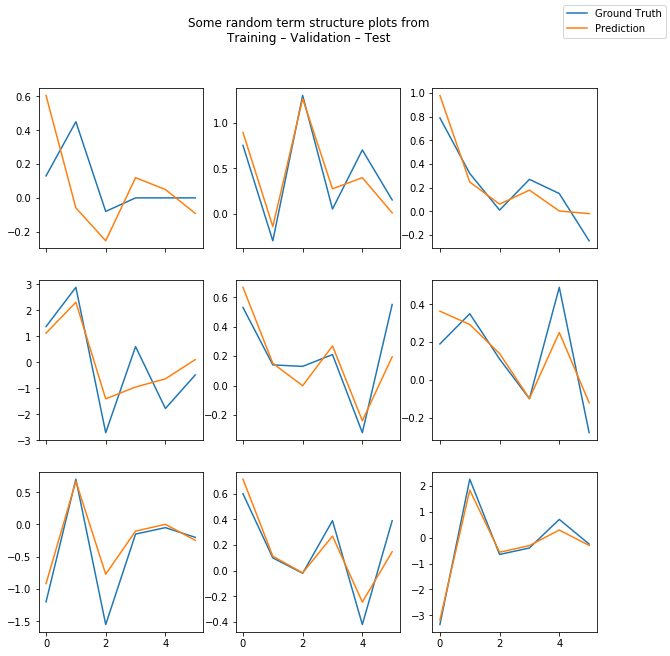

In [8]:
fig, axs = plt.subplots(3, 3, sharex=True, figsize=(10,10))
for axh in axs:
    i1 = random.randint(0, len(x_train) - 1)
    axh[0].plot(np.arange(6), y_train[i1],
                np.arange(6), np.squeeze(model_ex2.predict(np.expand_dims(x_train[i1], axis=0))))
    i2 = random.randint(0, len(x_val) - 1)
    axh[1].plot(np.arange(6), y_val[i2],
                np.arange(6), np.squeeze(model_ex2.predict(np.expand_dims(x_val[i2], axis=0))))
    i3 = random.randint(0, len(x_test) - 1)
    a,b = axh[2].plot(np.arange(6), y_test[i3],
                np.arange(6), np.squeeze(model_ex2.predict(np.expand_dims(x_test[i3], axis=0))))
plt.suptitle("Some random term structure plots from\nTraining – Validation – Test")
fig.legend((a, b), ("Ground Truth", "Prediction"))
plt.show()

In [9]:
results_frame = reduced_data.groupby("width").min().loc[:24]
results_frame.index = reduced_data.groupby("width").idxmin().loc[:24]
results_frame

mean                 std  \
                                                  loss  val_loss      loss   
((9, 979), (9, 942), (9, 500), (9, 959))      0.157211  0.151129  0.007609   
((12, 996), (12, 995), (12, 176), (12, 273))  0.144985  0.137009  0.010186   
((15, 997), (15, 856), (15, 989), (15, 996))  0.141112  0.116166  0.008449   
((18, 999), (18, 998), (18, 100), (18, 397))  0.124170  0.102543  0.005107   
((21, 997), (21, 795), (21, 88), (21, 123))   0.128186  0.105359  0.004363   
((24, 997), (24, 966), (24, 87), (24, 205))   0.122844  0.098353  0.004944   

                                                        
                                              val_loss  
((9, 979), (9, 942), (9, 500), (9, 959))      0.027593  
((12, 996), (12, 995), (12, 176), (12, 273))  0.028788  
((15, 997), (15, 856), (15, 989), (15, 996))  0.013542  
((18, 999), (18, 998), (18, 100), (18, 397))  0.004210  
((21, 997), (21, 795), (21, 88), (21, 123))   0.005029  
((24, 997), (24, 966), (24, 87), (24, 205))   0.003561

In [10]:
print(reduced_data.min(), reduced_data.idxmin(), sep="\n")

mean  loss        0.081440
      val_loss    0.086974
std   loss        0.001344
      val_loss    0.001685
dtype: float32
mean  loss        (87, 990)
      val_loss    (60, 723)
std   loss        (75, 860)
      val_loss    (27, 999)
dtype: object
